In [7]:
%%capture
!pip install transformers
!pip install torch
!pip install datasets
!pip install speechbrain
# !pip install "torchaudio<0.12"
!add-apt-repository -y ppa:jonathonf/ffmpeg-4 && apt update && apt install -y ffmpeg
!pip install torchaudio

import torch
from transformers import AutoModelWithLMHead, AutoTokenizer
from datasets import load_dataset
import datasets
import librosa
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import matplotlib.pyplot as plt
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration

import soundfile as sf


# Common voice dataset

In [ ]:
dataset = load_dataset(
  'common_voice',
  'nl'  # tag name, or branch name, or commit hash
)

  0%|          | 0/6 [00:00<?, ?it/s]

## XLSR Wav2Vec2 Dutch by Jonatas Grosman	

In [ ]:
# Suppress "PySoundFile failed. Trying audioread instead."
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
SAMPLES = 100


LANG_ID = "nl"
MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-dutch"


test_dataset = load_dataset("common_voice", LANG_ID, split=f"test[:{SAMPLES}]")

processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

# Preprocessing the datasets.
# We need to read the audio files as arrays
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = librosa.load(batch["path"], sr=16_000)
    batch["speech"] = speech_array
    batch["sentence"] = batch["sentence"].upper()
    return batch

test_dataset = test_dataset.map(speech_file_to_array_fn)
inputs = processor(test_dataset["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)

with torch.no_grad():
    logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits

predicted_ids = torch.argmax(logits, dim=-1)
predicted_sentences = processor.batch_decode(predicted_ids)

# for i, predicted_sentence in enumerate(predicted_sentences):
#     print("-" * 100)
#     print("Reference:", test_dataset[i]["sentence"])
#     print("Prediction:", predicted_sentence)


KeyboardInterrupt: ignored

In [ ]:
reference_sentences = [sentence.lower() for sentence in test_dataset[:len(predicted_sentences)]['sentence']] #lower the senteces as they are in ALL CAPS in the test corpus
wer_list = []
wrr_list = []



In [ ]:
reference_sentences = reference_sentences[:100]
predicted_sentences = predicted_sentences[:100]


In [ ]:
import re

def remove_punctuation(strings):
    # Compile a regular expression pattern to match punctuation characters
    pattern = re.compile(r'[^\w\s]')

    # Loop through the strings and remove the punctuation characters
    return [pattern.sub('', string) for string in strings]

reference_sentences = remove_punctuation(reference_sentences)

Text(0, 0.5, 'Character Error Rate')

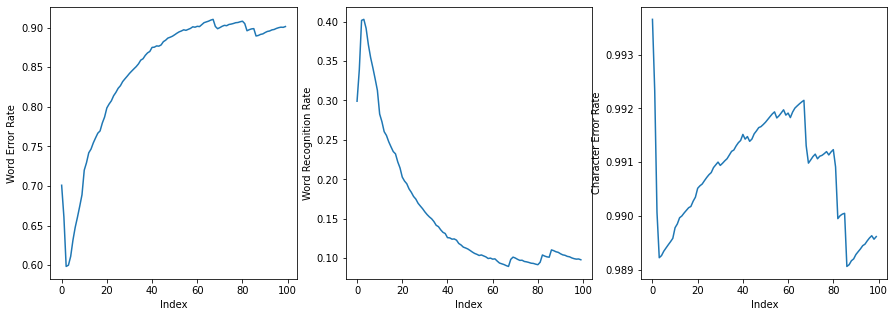

In [ ]:
wer_list = []
wrr_list = []
cer_list = []

# Loop through the reference and predicted sentences
for i in range(len(predicted_sentences)):
    reference_sentences.extend(reference_sentences[i].split())
    predicted_sentences.extend(predicted_sentences[i].split())

    # Calculate the number of words in the reference and predicted sentences
    num_words_reference = len(reference_sentences)
    num_words_predicted = len(predicted_sentences)

    # Calculate the number of correctly recognized words
    num_correct_words = sum([1 for i, j in zip(reference_sentences, predicted_sentences) if i == j])

    # Calculate the word error rate and word recognition rate
    wer = (num_words_reference - num_correct_words) / num_words_reference
    wrr = num_correct_words / num_words_predicted

    # Append the word error rate and word recognition rate to the lists
    wer_list.append(wer)
    wrr_list.append(wrr)

    # Calculate the number of characters in the reference and predicted sentences
    num_chars_reference = sum([len(word) for word in reference_sentences])
    num_chars_predicted = sum([len(word) for word in predicted_sentences])

    # Calculate the number of correctly recognized characters
    num_correct_chars = sum([1 for i, j in zip(reference_sentences, predicted_sentences) if i == j])

    # Calculate the character error rate
    cer = (num_chars_reference - num_correct_chars) / num_chars_reference

    # Append the character error rate to the list
    cer_list.append(cer)

# Visualize the word error rate, word recognition rate, and character error rate
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(wer_list)
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Word Error Rate")
axs[1].plot(wrr_list)
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Word Recognition Rate")
axs[2].plot(cer_list)
axs[2].set_xlabel("Index")
axs[2].set_ylabel("Character Error Rate")

## whisperlarge by OpenAI

In [28]:
# Load the model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-large")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")
LANG_ID = 'nl'
# Load the test set and cast the "audio" column to the Audio data type
ds = load_dataset("common_voice", LANG_ID, split="test")
ds = ds.cast_column("audio", datasets.Audio(sampling_rate=16_000))

# Set the decoder prompt IDs
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language = "nl", task = "transcribe")
predicted_sentences = []

# Iterate over the first 100 samples in the dataset and transcribe each one
for i, sample in enumerate(ds):
  if i >= 100:
    break
  input_speech = sample["audio"]["array"]
  input_features = processor(input_speech, return_tensors="pt").input_features
  predicted_ids = model.generate(input_features)
  transcription = processor.batch_decode(predicted_ids)
  transcription = processor.batch_decode(predicted_ids, skip_special_tokens = True)
  predicted_sentences.append(transcription)
  print(transcription)


/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[' Het containerschip lag aangemeerd in de haven.']
[' De bezorgdheid is dan wel minstens vier weken.']
[' De dolfijnen sprongen uit het water voor de boeg van het schip.']
[' Het vermiste jongetje droeg een geel t-shirt op de dag van de verdwijning.']
[' De regenpijp lekt weer.']
[' Met knikkende knieën liep ik het contour binnen.']
[' Ze brak haar arm op meerdere plekken.']
[' De smartphone maakt een gek geluid.']
[' Ik ben vergeten een cadeau te kopen.']
[' We moeten nog met de hond gaan wandelen.']
[' Gent, Brugge, Antwerpen, Leuven, Hasselt, Bergen, Namen, Alen, Waven en Luik zijn de hoofdsteden van de tien provincies in België.']
[' Vertel me alsjeblieft meer over je symptomen.']
[' De politie heeft een dossier geopend over die onrustwekkende verdwijning.']
[' Waar is de nooduitgang?']
[' Men zegt dat held niet gelukkig maakt.']
[' Een ronde kamer heeft geen hoeken.']
[' Op papier was hun relatie perfect.']
[' Robots zijn cool!']
[' Loopschoenen zijn ontwikkeld om optimale steun 

In [29]:
SAMPLES = 100
test_dataset = load_dataset("common_voice", LANG_ID, split=f"test[:{SAMPLES}]")


In [30]:
reference_sentences = [sentence.lower() for sentence in test_dataset[:len(predicted_sentences)]['sentence']] #lower the senteces as they are in ALL CAPS in the test corpus
predicted_sentences = [sentence.lower() for inner_list in predicted_sentences for sentence in inner_list] #lower the senteces as they have capitalized sentences in the predictions


wer_list = []
wrr_list = []



In [31]:
import re

def remove_punctuation(strings):
    # Compile a regular expression pattern to match punctuation characters
    pattern = re.compile(r'[^\w\s]')



    # Loop through the strings and remove the punctuation characters (also strip it)
    return [pattern.sub('', string).strip() for string in strings]

reference_sentences = remove_punctuation(reference_sentences)
predicted_sentences = remove_punctuation(predicted_sentences)

In [32]:
predicted_sentences

['het containerschip lag aangemeerd in de haven',
 'de bezorgdheid is dan wel minstens vier weken',
 'de dolfijnen sprongen uit het water voor de boeg van het schip',
 'het vermiste jongetje droeg een geel tshirt op de dag van de verdwijning',
 'de regenpijp lekt weer',
 'met knikkende knieën liep ik het contour binnen',
 'ze brak haar arm op meerdere plekken',
 'de smartphone maakt een gek geluid',
 'ik ben vergeten een cadeau te kopen',
 'we moeten nog met de hond gaan wandelen',
 'gent brugge antwerpen leuven hasselt bergen namen alen waven en luik zijn de hoofdsteden van de tien provincies in belgië',
 'vertel me alsjeblieft meer over je symptomen',
 'de politie heeft een dossier geopend over die onrustwekkende verdwijning',
 'waar is de nooduitgang',
 'men zegt dat held niet gelukkig maakt',
 'een ronde kamer heeft geen hoeken',
 'op papier was hun relatie perfect',
 'robots zijn cool',
 'loopschoenen zijn ontwikkeld om optimale steun te geven aan je voet',
 'ze zijn geëmigreerd n

Text(0, 0.5, 'Character Error Rate')

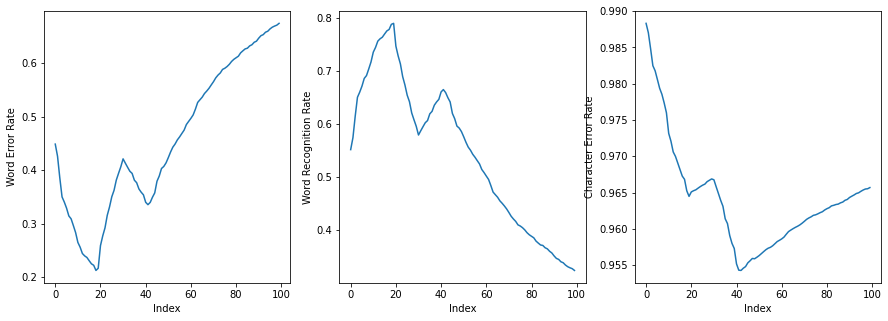

In [33]:
wer_list = []
wrr_list = []
cer_list = []

# Loop through the reference and predicted sentences
for i in range(len(predicted_sentences)):
    reference_sentences.extend(reference_sentences[i].split())
    predicted_sentences.extend(predicted_sentences[i].split())

    # Calculate the number of words in the reference and predicted sentences
    num_words_reference = len(reference_sentences)
    num_words_predicted = len(predicted_sentences)

    # Calculate the number of correctly recognized words
    num_correct_words = sum([1 for i, j in zip(reference_sentences, predicted_sentences) if i == j])

    # Calculate the word error rate and word recognition rate
    wer = (num_words_reference - num_correct_words) / num_words_reference
    wrr = num_correct_words / num_words_predicted

    # Append the word error rate and word recognition rate to the lists
    wer_list.append(wer)
    wrr_list.append(wrr)

    # Calculate the number of characters in the reference and predicted sentences
    num_chars_reference = sum([len(word) for word in reference_sentences])
    num_chars_predicted = sum([len(word) for word in predicted_sentences])

    # Calculate the number of correctly recognized characters
    num_correct_chars = sum([1 for i, j in zip(reference_sentences, predicted_sentences) if i == j])

    # Calculate the character error rate
    cer = (num_chars_reference - num_correct_chars) / num_chars_reference

    # Append the character error rate to the list
    cer_list.append(cer)

# Visualize the word error rate, word recognition rate, and character error rate
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(wer_list)
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Word Error Rate")
axs[1].plot(wrr_list)
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Word Recognition Rate")
axs[2].plot(cer_list)
axs[2].set_xlabel("Index")
axs[2].set_ylabel("Character Error Rate")

## facebook/s2t-medium-mustc-multilingual-**st**

In [13]:
# There are some issues with the code. Even when just running the sample code from HuggingFace

ValueError: ignored

In [ ]:
inputs